In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import shutil
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import rotate

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D
from keras import optimizers
from keras.models import Model

import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
# TensorFlow wizardry
config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13126101095463036637
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2654994432
locality {
  bus_id: 1
}
incarnation: 8259136067435965565
physical_device_desc: "device: 0, name: GeForce GTX 780, pci bus id: 0000:03:00.0, compute capability: 3.5"
]


In [4]:
path = "/mnt/ML-drive/scanner-ml/Artem/share/Valerio/"
class_names = ['C100keV','TestSample']
n_pols = 8

In [5]:
def load_images(path, name_dir='TestSample', n_pols=8):
    
    img_ind = []
    path = path+name_dir+"/crops/"
    img_names = os.listdir(path)
    for name in img_names:
        img_ind.append(re.split('[_.]',name))
    img_ind = pd.DataFrame(np.array(img_ind),columns=['ViewID','gr','GrainID','pol','Polarization','cl','ClusterID','csv'])
    img_ind = img_ind.drop(['csv'],axis=1).sort_values(['ViewID','GrainID','Polarization'])
    for view in np.unique(img_ind['ViewID']):
        view_imgs = img_ind[ img_ind['ViewID']==view ]
        for grain in np.unique(view_imgs['GrainID']):
            grain_imgs = view_imgs[ view_imgs['GrainID']==grain ]
            if grain_imgs.shape[0]!=8:
                img_ind = img_ind.drop(grain_imgs.index)
    img_names = []
    for name in img_ind.values:
        img_names.append('_'.join(name)+'.csv')
    
    i=0
    im_array = []
    for name in img_names:
        if i==0 : tmp_im = []
        tmp_im.append(pd.read_csv(path+name, header=None).drop(31, axis=1).values)
        i+=1
        if i==n_pols:
            im_array.append(np.array(tmp_im).T)
            i=0
    return np.array(im_array)

In [6]:
%%time
X_sign = load_images(path, 'C100keV')
y_sign = np.ones((X_sign.shape[0],1))
X_noise = load_images(path, 'TestSample')
y_noise = np.zeros((X_noise.shape[0],1))

X = np.vstack((X_sign, X_noise))
y = np.vstack((y_sign, y_noise))

CPU times: user 9min 13s, sys: 13.8 s, total: 9min 27s
Wall time: 10min 3s


# VGG 3D with rotations

(31, 31, 8)

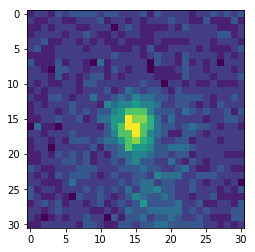

In [7]:
plt.imshow((X[1464].T)[0])
X[1464].shape

(1, 31, 31, 8)

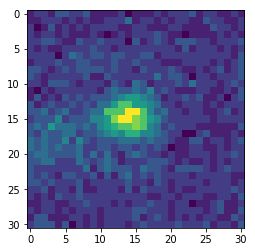

In [8]:
copa = rotate(X[1464], 90, mode='reflect', order=3, preserve_range=True)
plt.imshow((copa.T)[0])
np.array([copa]).shape

In [25]:
angles = np.append((np.random.rand(6)-0.5)*180, 0)
angles

array([ 22.70450706,  48.87868273,  34.23015659, -68.26740254,
        57.35423412, -47.51089747,   0.        ])

In [ ]:
#data with rotations
timeka = datetime.now()

X_rot = []
y_rot = []
y_rot_angle = []

for angle in angles:
    y_rot_angle = np.append(y_rot_angle, np.ones(X.shape[0])*angle)
y_rot_angle = y_rot_angle.reshape((y_rot_angle.shape[0],1))
    
for angle in angles:
    for i in np.arange(X.shape[0]):
        image = X[i]
        if angle != 0: rot_im = rotate(image, angle, mode='reflect', order=3, preserve_range=True)
        else: rot_im = image
        X_rot.append(rot_im)
        y_rot.append(y[i,0])
        if not(i%5000): print('time ', datetime.now()-timeka ,'\tfor ',i,' images   \tfor angle ',angle)

In [27]:
%%time
X_rot = np.array(X_rot).reshape((y_rot_angle.shape[0],*X.shape[1:],1))
y_rot = np.array([y_rot]).T

CPU times: user 1.46 s, sys: 2.16 s, total: 3.63 s
Wall time: 3.59 s


In [28]:
%%time

X_rot_train, X_rot_test, Y_rot_train, Y_rot_test, Y_rot_angle_train, Y_rot_angle_test = train_test_split(X_rot, y_rot, y_rot_angle, test_size=0.15, stratify=y_rot)

print ("X_3d_rot_train shape: " + str(X_rot_train.shape))
print ("Y_rot_train shape: " + str(Y_rot_train.shape))
print ("X_3d_rot_test shape: " + str(X_rot_test.shape))
print ("Y_rot_test shape: " + str(Y_rot_test.shape))

X_3d_rot_train shape: (137926, 31, 31, 8, 1)
Y_rot_train shape: (137926, 1)
X_3d_rot_test shape: (24341, 31, 31, 8, 1)
Y_rot_test shape: (24341, 1)
CPU times: user 2.52 s, sys: 1.83 s, total: 4.36 s
Wall time: 4.31 s


In [29]:
vgg_rot_hist = []
vgg_rot_hist_DXII = []

In [30]:
def DDD_VGG_rot_model(input_shape=(31,31,8,1), classes=2):
    
    
    X_input = Input(input_shape)

    X = Conv3D(64, 3, padding='same', activation='relu', name='conv1_1')(X_input)
    X = Conv3D(64, 3, padding='same', name='conv1_2')(X)
    #X = BatchNormalization(name='batch1')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    X = Conv3D(128, 3, padding='same', name='conv2')(X)
    #X = BatchNormalization(name='batch2')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D(name='pool2')(X)
    print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.5, name='drop_middle')(X)
    
    X = Conv3D(256, 3, padding='same', name='conv3')(X)
    #X = BatchNormalization(name='batch3')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D(name='pool3')(X)
    print('conv3\t',X.get_shape())
    
    X = Conv3D(512, 3, padding='same', name='conv4')(X)
    #X = BatchNormalization(name='batch4')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D(padding='same', name='pool4')(X)
    print('conv4\t',X.get_shape())
    
    X = Dropout(rate=0.5, name='drop')(X)
    
    X = Flatten()(X)
    X_class = Dense(1, activation='sigmoid', name='class')(X)
    X_angle = Dense(1, name='angle')(X)
    if classes != 2 : print('oh no, too many classes, change the model output to softmax!')
    
    model = Model(inputs = X_input, outputs = [X_class,X_angle], name='3D_VGG_rot_model')
    return model

In [31]:
adamka = optimizers.Adam(lr=1e-3, decay=1e-5)
ddd_vgg_rot_model = DDD_VGG_rot_model(input_shape=(31,31,8,1))
ddd_vgg_rot_model.compile(optimizer=adamka, loss=['binary_crossentropy','mean_squared_error'], loss_weights=[10.,0.01], metrics={'class':'accuracy','angle':'mae'})

conv1	 (?, 15, 15, 4, 64)
conv2	 (?, 7, 7, 2, 128)
conv3	 (?, 3, 3, 1, 256)
conv4	 (?, 2, 2, 1, 512)


In [ ]:
vgg_rot_hist_DXII.append(ddd_vgg_rot_model.fit(X_rot_train, [Y_rot_train, Y_rot_angle_train], epochs = 100, batch_size = 128, validation_split=0.15, verbose=1))

In [33]:
preds = ddd_vgg_rot_model.evaluate(X_rot_test, [Y_rot_test, Y_rot_angle_test])

24341/24341 [==============================] - 76s 3ms/step


In [34]:
print ("Loss = " + str(np.around(preds[0],decimals=2)))
print ("Test Accuracy = " + str(np.around(preds[3],decimals=3)))
print ('Test Angle MAE = ',np.around(preds[4],decimals=2))

Loss = 1.81
Test Accuracy = 0.958
Test Angle MAE =  5.41


/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


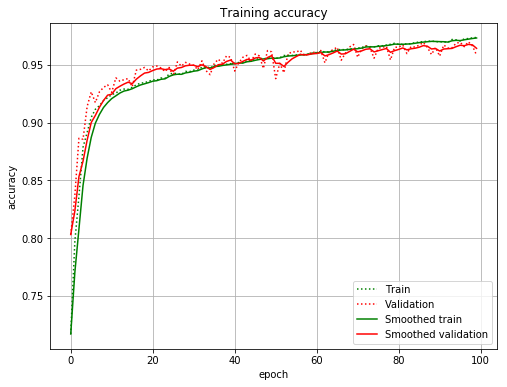

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


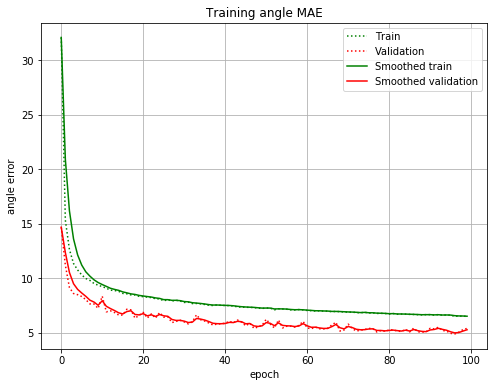

In [35]:
plt.figure(figsize=(8,6))
plt.title('Training accuracy')
plt.plot(vgg_rot_hist_DXII[-1].history['class_acc'], "g:", label='Train')
plt.plot(vgg_rot_hist_DXII[-1].history['val_class_acc'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['class_acc']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['val_class_acc']),span=5), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.savefig('acc_rot512.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.title('Training angle MAE')
plt.plot(vgg_rot_hist_DXII[-1].history['angle_mean_absolute_error'], "g:", label='Train')
plt.plot(vgg_rot_hist_DXII[-1].history['val_angle_mean_absolute_error'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['angle_mean_absolute_error']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(vgg_rot_hist_DXII[-1].history['val_angle_mean_absolute_error']),span=3), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('angle error')
plt.grid()
plt.legend()
plt.savefig('angle_rot512.pdf')
plt.show()

In [36]:
with open('angles.txt','w') as file:
    file.write('\t'.join(map(str,np.around(angles,decimals=2))))

In [41]:
def CNN_model(input_shape=(31,31,8), classes=2):
    
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((1,1))(X_input)
    X = Conv2D(64, 3, name='conv1')(X)
    #X = BatchNormalization(name='batch1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    X = Flatten()(X)
    X_class = Dense(1, activation='sigmoid', name='class')(X)
    X_angle = Dense(1, name='angle')(X)
    if classes != 2 : print('oh no, too many classes, change the model output to softmax!')
    
    model = Model(inputs = X_input, outputs = [X_class, X_angle], name='Simple_2D_rot_model')
    return model

In [ ]:
cnn_model = CNN_model(input_shape=(31,31,8))
nadamka = keras.optimizers.Nadam(lr=1e-4)
cnn_model.compile(optimizer=nadamka, loss=['binary_crossentropy','mean_squared_error'], loss_weights=[1.,0.01], metrics={'class':'accuracy','angle':'mae'})
hist_dd = cnn_model.fit(np.squeeze(X_rot_train), [Y_rot_train, Y_rot_angle_train], epochs = 400, batch_size = 256, validation_split=0.15)

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  """
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


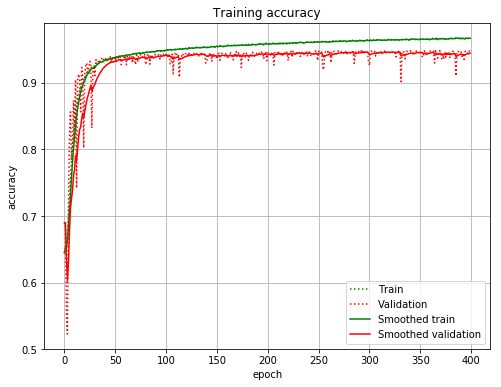

/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
/home/scanner-ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


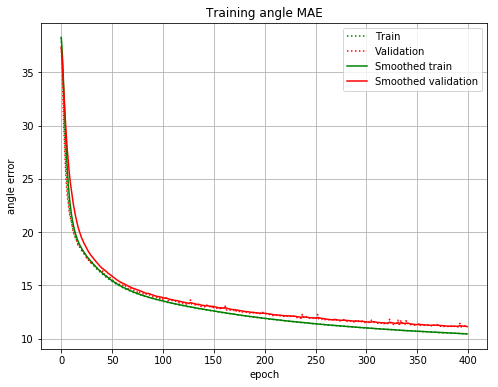

In [48]:
plt.figure(figsize=(8,6))
plt.title('Training accuracy')
plt.plot(hist_dd.history['class_acc'], "g:", label='Train')
plt.plot(hist_dd.history['val_class_acc'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist_dd.history['class_acc']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist_dd.history['val_class_acc']),span=15), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.savefig('acc_simple_rot.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.title('Training angle MAE')
plt.plot(hist_dd.history['angle_mean_absolute_error'], "g:", label='Train')
plt.plot(hist_dd.history['val_angle_mean_absolute_error'], "r:", label='Validation')
plt.plot(pd.ewma(np.array(hist_dd.history['angle_mean_absolute_error']),span=3), "g", label='Smoothed train')
plt.plot(pd.ewma(np.array(hist_dd.history['val_angle_mean_absolute_error']),span=10), "r", label='Smoothed validation')
plt.xlabel('epoch')
plt.ylabel('angle error')
plt.grid()
plt.legend()
plt.savefig('angle_simple_rot.pdf')
plt.show()

In [40]:
vgg_rot_hist[-1].history.keys()

dict_keys(['val_loss', 'val_class_loss', 'val_angle_loss', 'val_class_acc', 'val_angle_mean_absolute_error', 'loss', 'class_loss', 'angle_loss', 'class_acc', 'angle_mean_absolute_error'])